**Prática de Segmentação de imagens**

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

1) Faça a plotagem do histograma da imagem, observando o histograma, escolha um valor para definir um threshold

In [3]:
def threshold_img(img, threshold, inverted_colors = True):
    new_img = np.zeros(img.shape)
    if inverted_colors:
        new_img = np.where(img > threshold, 0, 255)
    else:
        new_img = np.where(img > threshold, 255, 0)
    
    return new_img

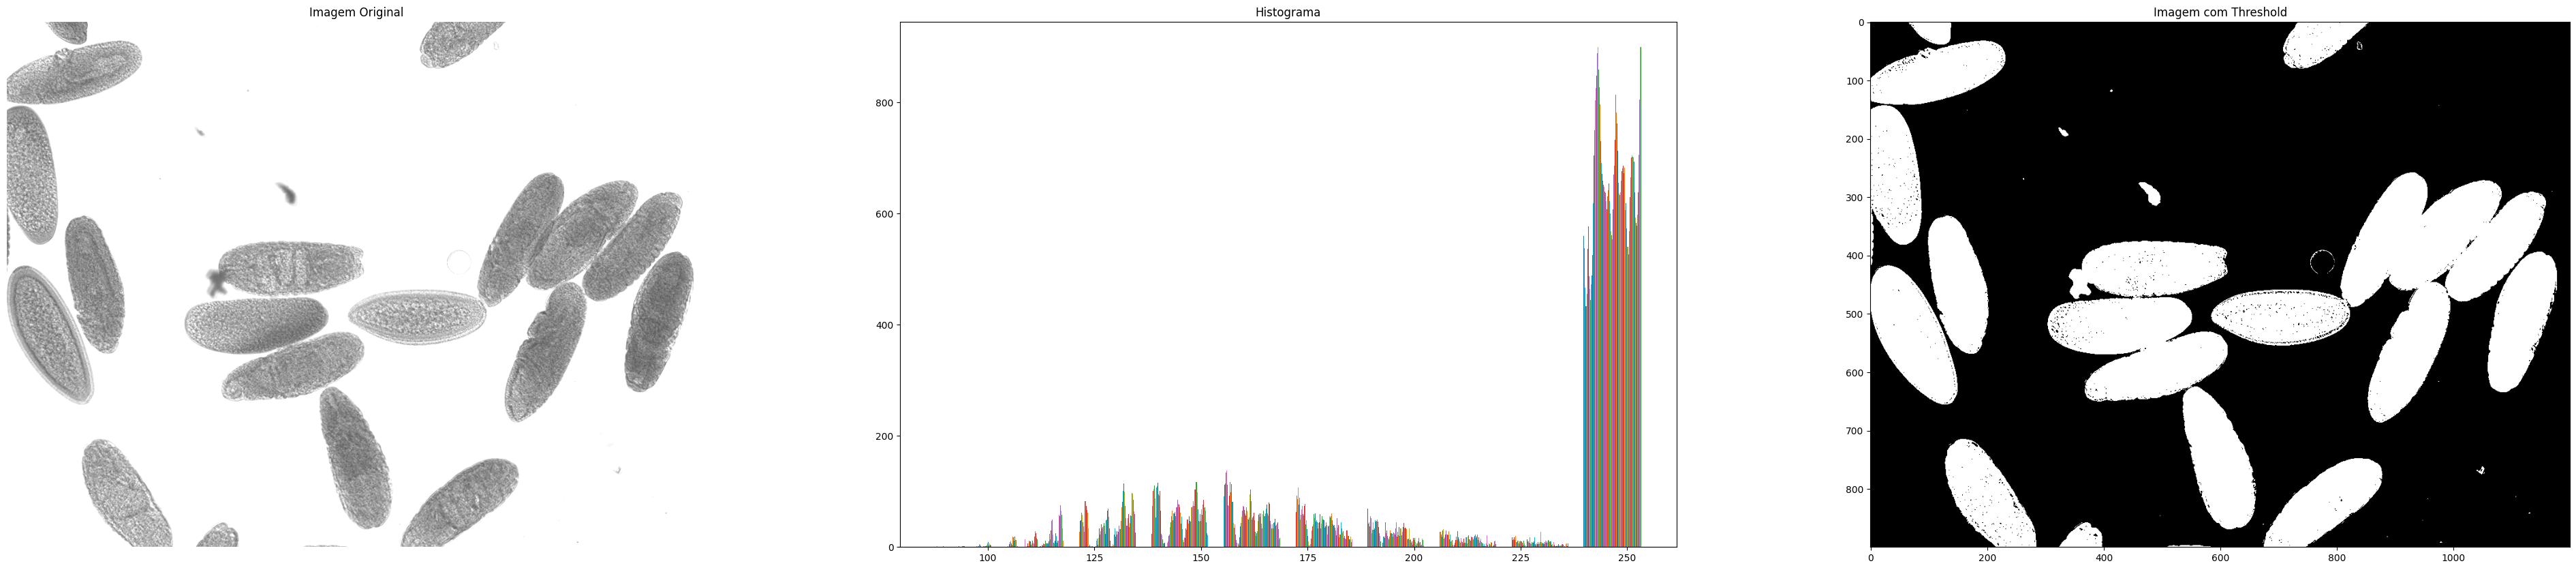

In [4]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.axis("off")
plt.title("Imagem Original")

plt.subplot(1,3,2)
plt.hist(img1)
plt.title("Histograma")

new_img = threshold_img(img1, 240)

plt.subplot(1,3,3)
plt.imshow(new_img, cmap="gray")
plt.title("Imagem com Threshold")



plt.show()

2)	Segmentação utilizando a técnica de Threshold Adaptativo (implementar o algortimo). Faça a aplicação do Threshold com e sem suavização prévia

In [5]:
def image_blur(img, _kernel_size): # Importando do Lab04
    width, height = img.shape

    kernel_size = _kernel_size
    half_kernel = kernel_size // 2
    new_img = np.zeros_like(img)

    for i in range(half_kernel, width - half_kernel):
        for j in range(half_kernel, height - half_kernel):
            pixels = img[i - half_kernel: i + half_kernel + 1, j - half_kernel: j + half_kernel + 1]
            new_pixel = np.mean(pixels)
            new_img[i, j] = new_pixel
    return new_img

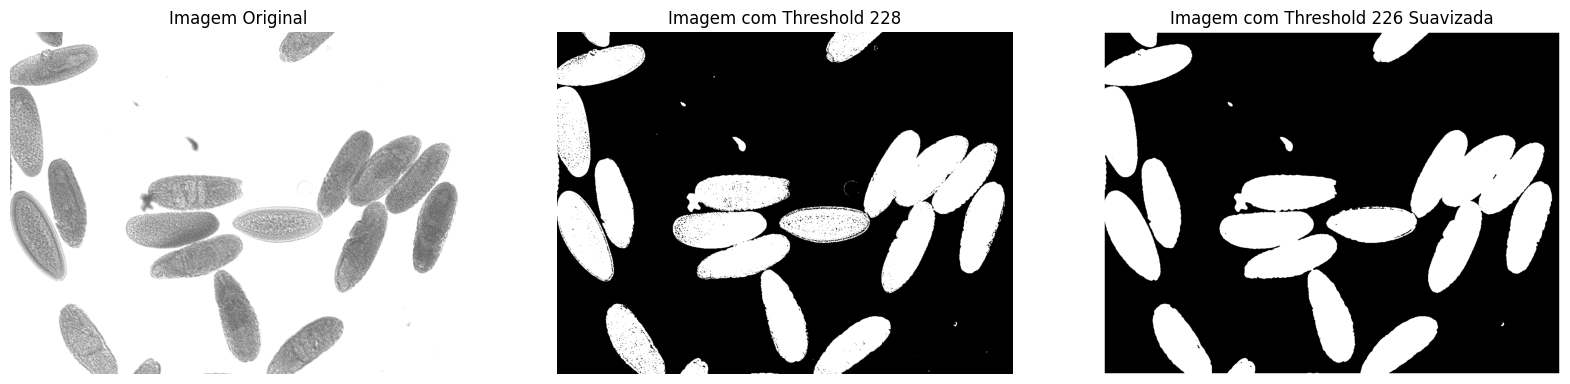

In [6]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.title("Imagem Original")
plt.axis("off")


def auto_threshold(img):
    threshold = 0
    delta_t = 0.1
    # Selecionar uma estimativa inicial para o T, entre min e max
    sum = np.sum(img)
    average = sum/(img.shape[0] * img.shape[1])
    threshold = average # Ou np.mean(img)
    old_threshold = 300 # Inicializando com valor impossivel pois python nao tem do while
    
    # Segmentar imagem usando T, gerando 2 grupos
    while(delta_t < threshold - old_threshold):
        group_1 = img[img >= threshold]
        group_2 = img[img < threshold]

        # Computar media das intensidade em cada regiao
        mean_g1 = np.mean(group_1)
        mean_g2 = np.mean(group_2)

        # Computar novo valor de T
        old_threshold = threshold
        threshold = (mean_g1 + mean_g2)/2
        # Repetir passos 2 a 4 ate que a diferenca de valores sucessivos de T seja menor ou igual a delta T
    return int(threshold)

threshold = auto_threshold(img1)
threshold_wo_smoothing = threshold_img(img1, threshold)

plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(threshold_wo_smoothing, cmap="gray")
plt.title(f"Imagem com Threshold {threshold}")

blurred_img = image_blur(img1, 5)
threshold = auto_threshold(blurred_img)
threshold_w_smoothing = threshold_img(blurred_img, threshold)
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(threshold_w_smoothing, cmap="gray")
plt.title(f"Imagem com Threshold {threshold} Suavizada")



plt.show()


3) Segmentação utilizando a técnica de Otsu (implementar) . Faça a aplicação do Threshold com e sem suavização prévia. Mostre um gráfico com o histograma juntamente com a variância entre classes (Exemplo: https://en.wikipedia.org/wiki/File:Otsu%27s_Method_Visualization.gif)

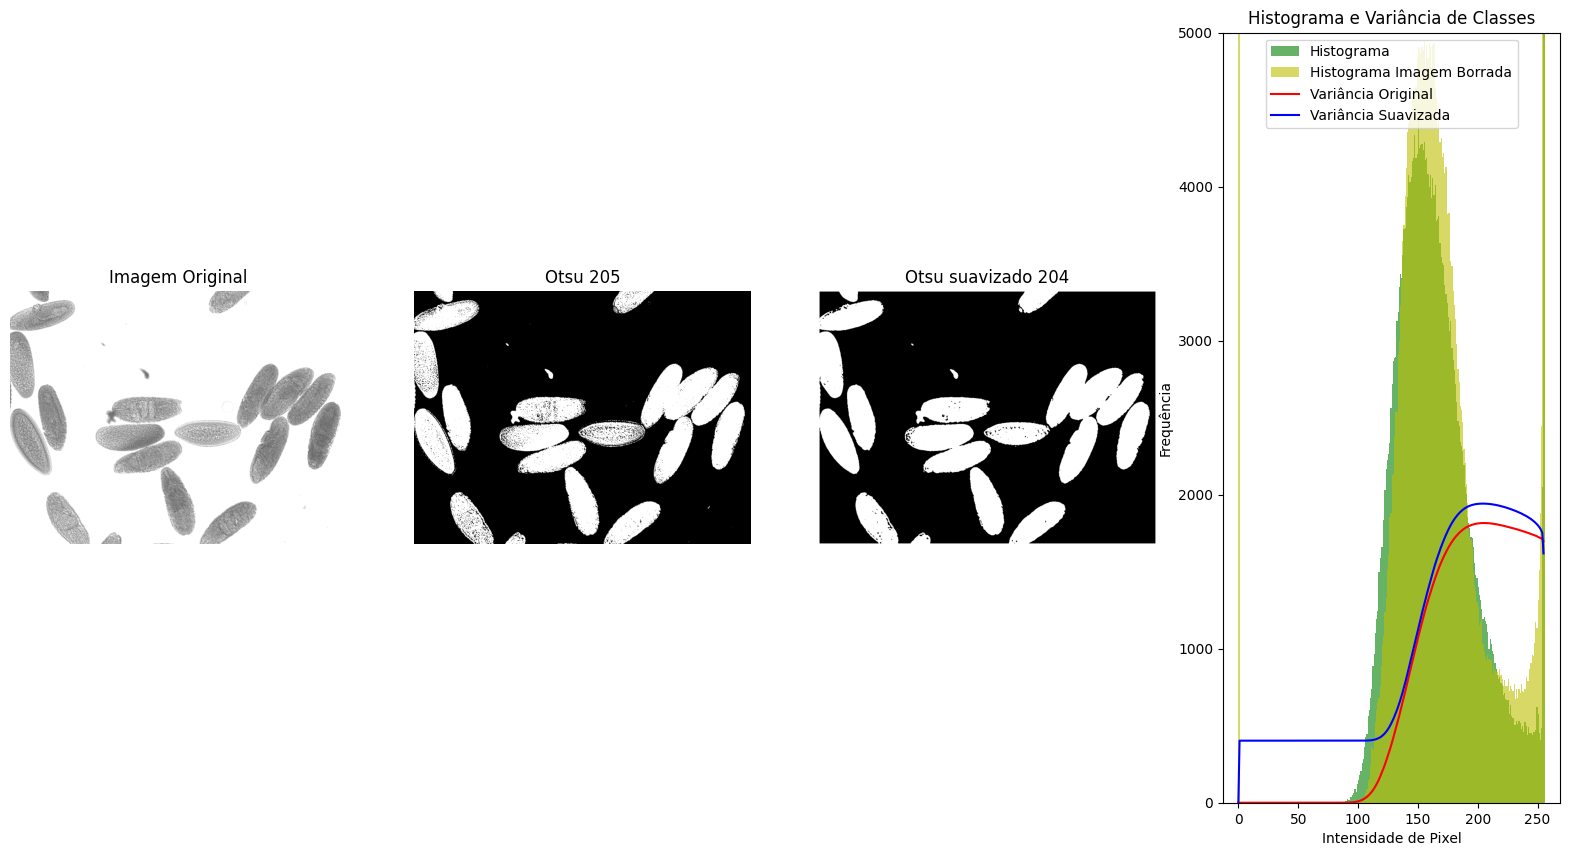

In [27]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.title("Imagem Original")
plt.axis("off")


def otsu(img):
    k = int(np.mean(img))
    # Calcular o histograma normalizado da imagem pi
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0, 256])
    pi = hist / np.sum(hist)
    max_sigma = 0
    k_opt = 0
    variances = []

    # Calcular P1 e P2
    for k in range(0, 256):
        p1 = np.sum(pi[0:k])
        p2 = 1 - p1

        if p1 == 0 or p2 == 0:
            variances.append(0)
            continue

        # Calcular u1 e u2
        u1 = np.sum(np.arange(k) * pi[0:k]) / p1
        u2 = np.sum(np.arange(k, 256) * pi[k:]) / p2

        # Calcular ug
        ug = p1 * u1 + p2 * u2

        # Calcular a variância entre as classes sigma
        sigma = p1 * (u1 - ug)**2 + p2 * (u2 - ug)**2
        variances.append(sigma)
        
        # Obter limiar de Otsu k
        if sigma > max_sigma:
            max_sigma = sigma
            k_opt = k

    return int(k_opt), variances

threshold, variances = otsu(img1)
otsu_img = threshold_img(img1, threshold)
plt.subplot(1,4,2)
plt.imshow(otsu_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Otsu {threshold}")
plt.axis("off")

blurred_img = image_blur(img1,5)
threshold_blurred, variances_blurred = otsu(blurred_img)
otsu_blurred = threshold_img(blurred_img, threshold_blurred)

plt.subplot(1,4,3)
plt.imshow(otsu_blurred, cmap='gray', vmin=0, vmax=255)
plt.title(f"Otsu suavizado {threshold_blurred}")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.hist(img1.flatten(), bins=256, range=[0, 256], alpha=0.6, color='g', label='Histograma')
plt.hist(blurred_img.flatten(), bins=256, range=[0, 256], alpha=0.6, color='y', label='Histograma Imagem Borrada')
plt.ylim(0, 5000)
plt.plot(variances, color='r', label='Variância Original')
plt.plot( variances_blurred, color='b', label='Variância Suavizada')
plt.title("Histograma e Variância de Classes")
plt.xlabel("Intensidade de Pixel")
plt.ylabel("Frequência")
plt.legend()
plt.axis("on")

plt.show()

4)	Aplique o Otsu para a imagem HE.jpg, madrill.tiff e  Lenna.jpg (use antes a conversão da imagem para tons de cinza)

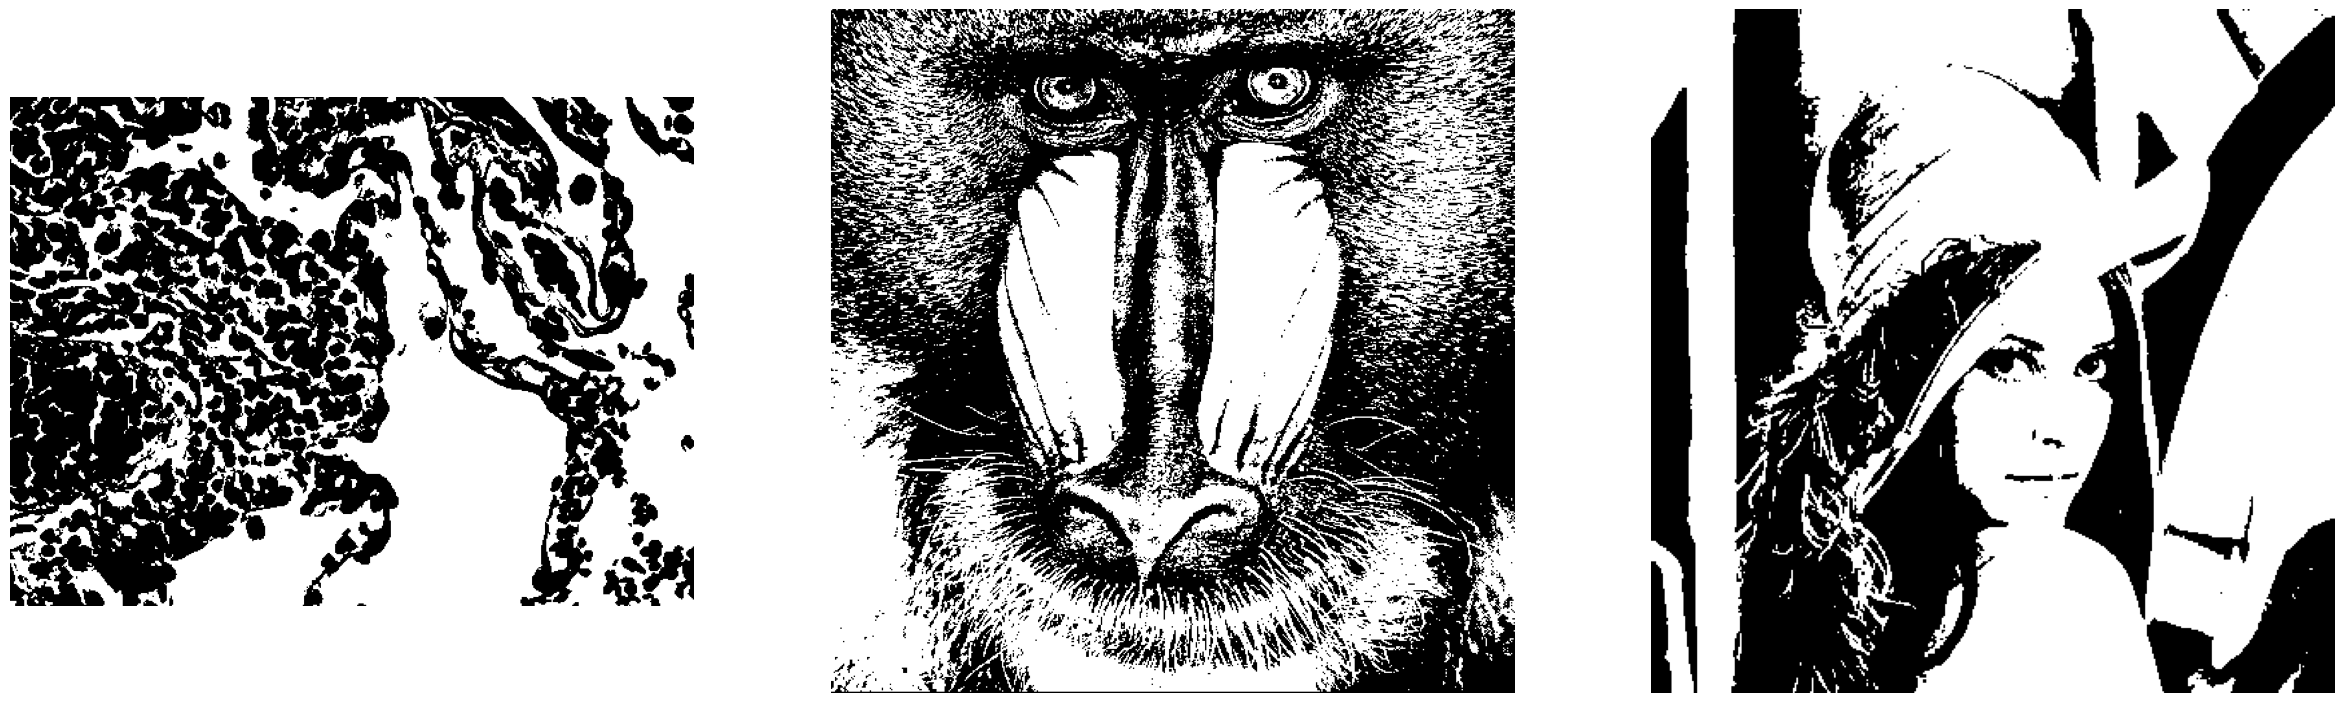

In [8]:
he = cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE)
madrill = cv2.imread("madrill.tiff", cv2.IMREAD_GRAYSCALE)
lenna = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

def apply_otsu_and_plot(img):
    threshold, _ = otsu(img)
    t_img = threshold_img(img, threshold,  False)
    plt.axis("off")
    plt.imshow(t_img, cmap='gray', vmin=0, vmax=255)
plt.figure(figsize=(30,10))

images = [he, madrill, lenna]
for i in range(3):
    plt.subplot(1,3,i + 1)
    apply_otsu_and_plot(images[i])